In [1]:
import sys, os

hpath = '/rds/general/user/cb2714/home/wwa/'
if os.path.exists("/home/cb2714/wwa/wwa.py"): hpath = '/home/cb2714/wwa/'
sys.path.append(hpath)
from wwa import *

fpath = "/rds/general/user/cb2714/home/00_WWA_project_folder/ephemeral/cali-wildfires/"

In [2]:
rnm = "socal-baja"
sf = gpd.read_file("sf_socal-baja/").to_crs(epsg = 4326)

Xn, Xx, Yn, Yx = [-125,-110,30,40]   # larger box for extracting data
xn, xx, yn, yx = [-121,-116,32,35]   # extent for figures

la = [-118.24, 34.05]

mapproj = cartopy.crs.PlateCarree()

states = regionmask.defined_regions.natural_earth_v5_0_0.us_states_50.to_geodataframe().clip((xn,yn,xx,yx))



days = pd.date_range(start = "2020-01-01", end = "2021-01-01")
labelticks = [i+1 for i in range(366) if (days[i].day) == 15]
labels = [days[i].strftime("%b")[0] for i in range(366) if (days[i].day) == 15]

# Physical geography

In [ ]:
elev = wrap_lon(xr.open_dataset("/rds/general/user/cb2714/home/00_WWA_project_folder/live/data/elev.0.25-deg.nc", decode_times = False).squeeze(drop = True).data).sel(lon = slice(xn,xx), lat = slice(yn,yx))

In [ ]:
fig, ax = plt.subplots(ncols = 1, nrows = 1, figsize = (7,5), dpi = 100, subplot_kw = {"projection" : mapproj})

elev.plot(ax = ax, cmap = "terrain", vmin = -750, vmax = 3000)

ax.gridlines(crs=cartopy.crs.PlateCarree(), linewidth=0.5, color='black', draw_labels=["bottom", "left"], alpha=0.2)
states.boundary.plot(ax = ax, color = "k", alpha = 0.3, lw = 1)
ax.add_feature(cartopy.feature.BORDERS, lw = 1, alpha = 0.7, ls = "--", zorder = 99)
ax.coastlines()

# gacc.boundary.plot(ax = ax, color = "firebrick", lw = 2, ls = "--")
sf.boundary.plot(ax = ax, color = "darkred", lw = 2)
ax.scatter(*la, marker = "x", color = "k", lw = 2)

# Fire indices

## Event maps (MSWX)

In [3]:
da = xr.open_dataset("/rds/general/user/cb2714/home/00_WWA_project_folder/ephemeral/cali-wildfires/mswx/fwi_mswx_2024-2025.nc")
da = da.sel(time = slice("2025-01-07", None))

vcols = {"dc" : "Oranges", "dmc" : "Oranges", "ffmc" : "Oranges", "isi" : "Oranges", "bui" : "Oranges", "fwi" : "Oranges"}
vmaxes = {"dc" : 2500, "dmc" : 1500, "ffmc": 100, "isi" : 500, "bui" : 1500, "fwi" : 500}

In [20]:
for varnm in vcols.keys():

    fig = da[varnm].plot(col = "time", col_wrap = 4, figsize = (18,6), subplot_kws = {"projection" : mapproj, "extent" : (xn,xx,yn,yx)}, cmap = vcols[varnm], vmin = 0, vmax = vmaxes[varnm],
                                            cbar_kwargs = {"fraction" : 0.025, "pad" : 0.01, "shrink" : 0.85}, sharex = True, sharey = True)
    plt.suptitle(varnm, fontweight = "bold")

    for ax in fig.axs.flat:
        ax.coastlines()
        sf.boundary.plot(ax = ax, color = "darkblue")
        ax.scatter(*la, marker = "x", color = "k", lw = 2)
        states.boundary.plot(ax = ax, color = "k", alpha = 0.3, lw = 1)
        ax.add_feature(cartopy.feature.BORDERS, lw = 1, alpha = 0.7, ls = "--", zorder = 99)

    plt.savefig("/rds/general/user/cb2714/home/wwa/25-01_california-wildfires/fig/event-map_"+varnm+"-2025_mswx.png"); plt.close()

## Time series vs previous years


In [3]:
days = pd.date_range(start = "2020-07-01", end = "2021-07-01")
labelticks = [i+1 for i in range(366) if (days[i].day) == 15]
labels = [days[i].strftime("%b")[0] for i in range(366) if (days[i].day) == 15]

In [4]:
ds = "era5"

for varnm in ["pr", "dc", "dmc", "ffmc", "bui", "isi", "fwi", "dsr", "fwimax", "fwiq95", "tas", "hurs", "sfcWind", "hdwi", "hdwimax"]:
    
    fnm = "data/"+ds+"_"+varnm+"_"+rnm+".nc"
    if not os.path.exists(fnm): continue
        
    ts = xr.open_dataset(fnm)[varnm]
    ts = ts.assign_coords(offset_time = ("time", ts.time.shift(time = 181).data))

    fig, axs = plt.subplots(ncols = 1, figsize = (6,4), dpi = 100, sharex = True, sharey = True)
    axs = [axs]

    for i in range(1):

        ax = axs[i]

        for y in range(1991,2020):
            ts_y = ts.sel(time = ts.offset_time.dt.year == y)
            ax.plot(ts_y.offset_time.dt.dayofyear, ts_y, color = "tab:blue", alpha = 0.5, label = "_years")

        y = 1991; ts_y = ts.sel(time = ts.offset_time.dt.year == y); ax.plot(ts_y.offset_time.dt.dayofyear, ts_y, color = "tab:blue", alpha = 0.3, label = "1991-2020")
    #     y = 2023; ts_y = ts.sel(time = ts.offset_time.dt.year == y); ax.plot(ts_y.offset_time.dt.dayofyear, ts_y, color = "darkblue", label = "2024-2025")
        y = 2024; ts_y = ts.sel(time = ts.offset_time.dt.year == y); ax.plot(ts_y.offset_time.dt.dayofyear, ts_y, color = "k", label = "2024-2025")

        ylim = ax.get_ylim()
        if varnm in ["pr"]:
            ax.add_patch(Rectangle((92, 0), 92, ylim[1]+10, color = "gold", alpha = 0.3))
        else:
            ax.add_patch(Rectangle((153, 0), 61, ylim[1]+10, color = "gold", alpha = 0.3))
        ax.set_ylim(ylim)
    
        ax.legend()
        ax.set_xticks(labelticks)
        ax.set_xticklabels(labels)
        [ax.axvline(x, color = "k", alpha = 0.05) for x in range(365) if (days[x].day) == 1]

        ax.set_title(varnm)

    plt.savefig("fig/daily-ts_"+varnm+"_"+ds+".png"); plt.close()

### 2024-25 vs climatology

In [138]:
varnm = "pr"
ts = xr.open_dataset("data/era5_"+varnm+"_"+rnm+".nc")[varnm]
ts = ts.assign_coords(offset_time = ("time", ts.time.shift(time = 181).data))

mmean = ts.sel(time = slice("1990","2020")).groupby("offset_time.month").mean()
msd = ts.sel(time = slice("1990","2020")).groupby("offset_time.month").std()
m_upper = mmean+msd
m_lower = mmean-msd

y2024 = ts.sel(time = ts.offset_time.dt.year == 2024).groupby("offset_time.month").mean()

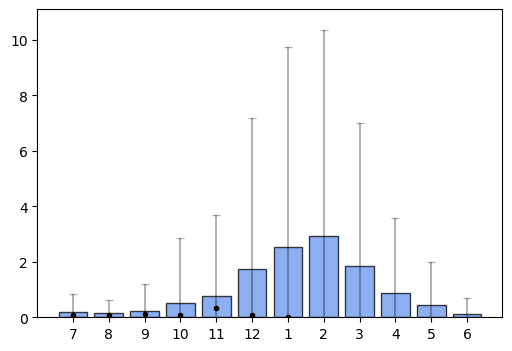

In [139]:
fig, axs = plt.subplots(ncols = 1, figsize = (6,4), dpi = 100, sharex = True, sharey = True)
axs = [axs]

for i in range(1):
    
    ax = axs[i]
    ax.bar(mmean.month, mmean, color = "cornflowerblue", edgecolor = "k", alpha = 0.75)
    
    for m in range(12):
        ax.plot([m+1,m+1], [m_lower.sel(month = m+1), m_upper.sel(month = m+1)], color = "k", alpha = 0.3, marker = "_", solid_capstyle = "butt")
        
    ax.plot(y2024.month, y2024, marker = ".", ls = "", color = "k", label = "2024")
        
    ax.set_xticks(range(1,13))
    ax.set_xticklabels(list(range(7,13)) + list(range(1,7)))
    ax.set_ylim(0)

## Accumulations vs previous years

In [6]:
days = pd.date_range(start = "2020-07-01", end = "2021-07-01")
labelticks = [i+1 for i in range(366) if (days[i].day) == 15]
labels = [days[i].strftime("%b")[0] for i in range(366) if (days[i].day) == 15]

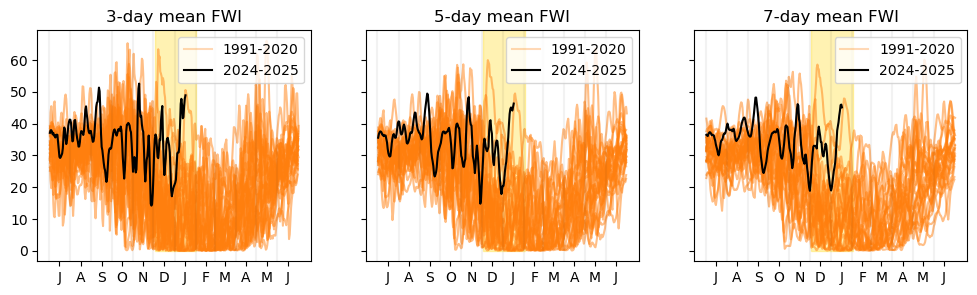

In [9]:
fwi = xr.open_dataset("data/era5_fwi_socal-baja.nc").fwi
fwi = fwi.assign_coords(offset_time = ("time", fwi.time.shift(time = 181).data))

ndays = [3,5,7]

nc = len(ndays)
fig, axs = plt.subplots(ncols = nc, figsize = (nc*4,3), dpi = 100, sharey = True)

for i in range(nc):
    ax = axs[i]
    ts = fwi.rolling(time = ndays[i]).mean()



    for y in range(1991,2020):
        ts_y = ts.sel(time = ts.offset_time.dt.year == y)
        ax.plot(ts_y.offset_time.dt.dayofyear, ts_y, color = "tab:orange", alpha = 0.5, label = "_years")

    y = 1991; ts_y = ts.sel(time = ts.offset_time.dt.year == y); ax.plot(ts_y.offset_time.dt.dayofyear, ts_y, color = "tab:orange", alpha = 0.3, label = "1991-2020")

    #     y = 2023; ts_y = ts.sel(time = ts.offset_time.dt.year == y); ax.plot(ts_y.offset_time.dt.dayofyear, ts_y, color = "darkblue", label = "2024-2025")
    y = 2024; ts_y = ts.sel(time = ts.offset_time.dt.year == y); ax.plot(ts_y.offset_time.dt.dayofyear, ts_y, color = "k", label = "2024-2025")

    ylim = ax.get_ylim()
    ax.add_patch(Rectangle((155, 0), 61, 80, color = "gold", alpha = 0.3))
    ax.set_ylim(ylim)
    
    ax.legend()
    ax.set_xticks(labelticks)
    ax.set_xticklabels(labels)
    [ax.axvline(x, color = "k", alpha = 0.05) for x in range(365) if (days[x].day) == 1]

    ax.set_title(str(ndays[i])+"-day mean FWI")
plt.savefig("fig/n-day_fwi_era5.png")

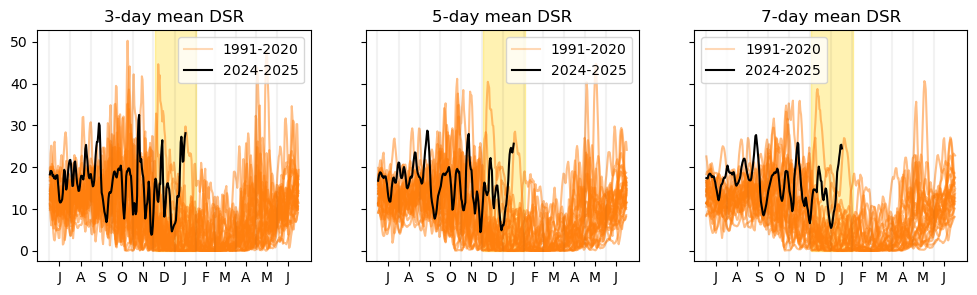

In [10]:
dsr = xr.open_dataset("data/era5_dsr_socal-baja.nc").dsr
dsr = dsr.assign_coords(offset_time = ("time", dsr.time.shift(time = 181).data))

ndays = [3,5,7]

nc = len(ndays)
fig, axs = plt.subplots(ncols = nc, figsize = (nc*4,3), dpi = 100, sharey = True)

for i in range(nc):
    ax = axs[i]
    ts = dsr.rolling(time = ndays[i]).mean()

    for y in range(1991,2020):
        ts_y = ts.sel(time = ts.offset_time.dt.year == y)
        ax.plot(ts_y.offset_time.dt.dayofyear, ts_y, color = "tab:orange", alpha = 0.5, label = "_years")

    y = 1991; ts_y = ts.sel(time = ts.offset_time.dt.year == y); ax.plot(ts_y.offset_time.dt.dayofyear, ts_y, color = "tab:orange", alpha = 0.3, label = "1991-2020")
    #     y = 2023; ts_y = ts.sel(time = ts.offset_time.dt.year == y); ax.plot(ts_y.offset_time.dt.dayofyear, ts_y, color = "darkblue", label = "2024-2025")
    y = 2024; ts_y = ts.sel(time = ts.offset_time.dt.year == y); ax.plot(ts_y.offset_time.dt.dayofyear, ts_y, color = "k", label = "2024-2025")

    ylim = ax.get_ylim()
    ax.add_patch(Rectangle((155, 0), 61, 80, color = "gold", alpha = 0.3))
    ax.set_ylim(ylim)

    ax.legend()
    ax.set_xticks(labelticks)
    ax.set_xticklabels(labels)
    [ax.axvline(x, color = "k", alpha = 0.05) for x in range(365) if (days[x].day) == 1]

    ax.set_title(str(ndays[i])+"-day mean DSR")
plt.savefig("fig/n-day_dsr_era5.png")

## Fire season

In [270]:
fwi = xr.open_dataset("data/era5_fwi_socal-baja.nc").fwi.sel(time = slice(None, "2024"))
fwi = fwi.assign_coords(offset_time = ("time", fwi.time.shift(time = 31).data))

rs = {str(ndays) : dict(zip(["onsets", "ends", "durations"], rainy_season(fwi, sm = ndays, t_0 =  31))) for ndays in [5,10,15,20]}

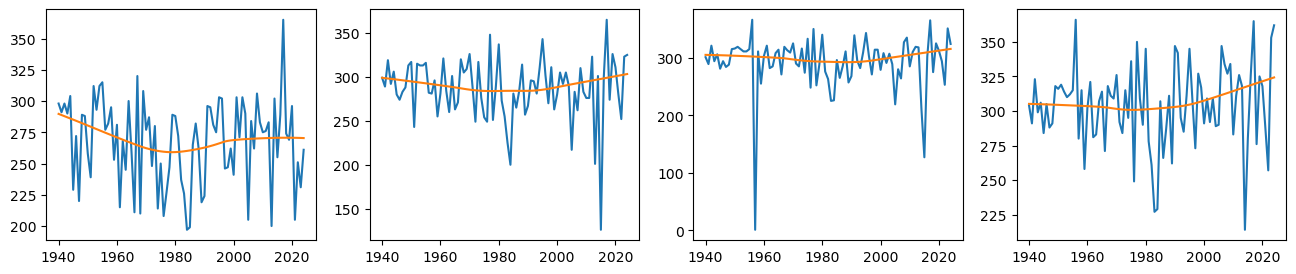

In [269]:
nc = len(rs)
fig, axs = plt.subplots(ncols = nc, figsize = (nc*4, 3), dpi = 100)

for i in range(nc):
    ax = axs[i]
    ndays = list(rs.keys())[i]

    ends = rs[ndays]["ends"]
    sm = lowess(ends.values, ends.year.values)[:,1]
    
    ax.plot(ends.year, ends)
    ax.plot(ends.year, sm)

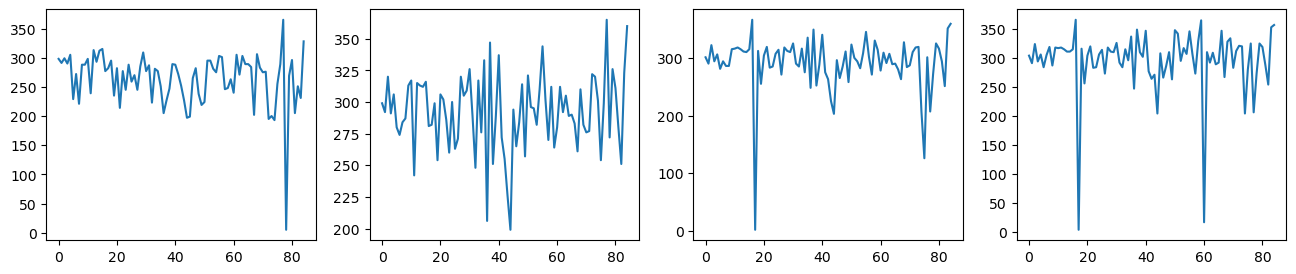

In [ ]:
    ts.plot(ax = ax, marker = ".", ls = "")
    ax.plot(ts.time, sm)
    ax.plot(ts.time, np.poly1d(np.polyfit(ts.time.dt.year, ts, 1))(np.sort(ts.time.dt.year)), color = "tab:blue")

In [233]:
for ndays in rs.keys():
    col = {"5" : "tab:blue", "10" : "tab:orange", "15" : "tab:green", "20":"tab:red"}[ndays]
    onsets.plot(marker = ".", ls = "", color = col)

    plt.gca().plot(onsets.year, np.poly1d(np.polyfit(onsets.year, onsets, 1))(np.sort(onsets.year)), color = col)

NameError: name 'onsets' is not defined

## FWI3x

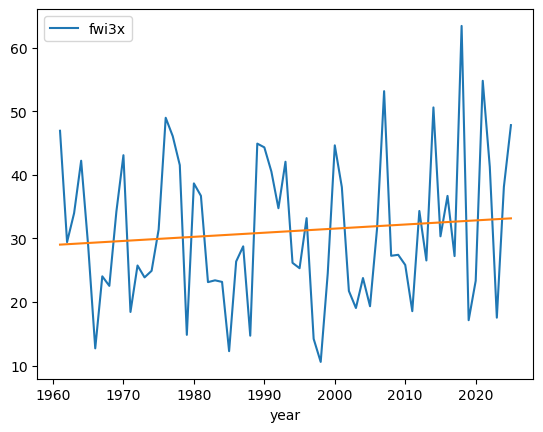

In [231]:
fwi = pd.read_csv("ts/era5_fwi3x-dj_socal-baja.csv", index_col = "year")
fwi = fwi.loc[fwi.index > 1960]

fwi.plot()
xyline(fwi.index, fwi.fwi3x, ax = plt.gca())


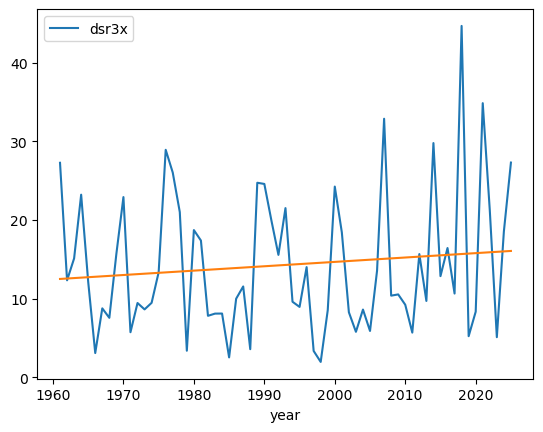

In [232]:
dsr = pd.read_csv("ts/era5_dsr3x-dj_socal-baja.csv", index_col = "year")
dsr = dsr.loc[dsr.index > 1960]

dsr.plot()
xyline(dsr.index, dsr.dsr3x, ax = plt.gca())
# xyline(fwi.loc[slice("1960",None)].index, fwi.loc[slice("1960",None)].fwi3x, ax = plt.gca())

---
# Onset of rainy season



## Lukovic definition / xclim

https://agupubs.onlinelibrary.wiley.com/doi/full/10.1029/2021GL092843  
https://agupubs.onlinelibrary.wiley.com/doi/full/10.1029/2020GL090350

In [3]:
from xclim.indices._agro import rain_season

In [244]:
pr = xr.open_dataset("data/era5_pr_socal-baja.nc").pr.assign_attrs(units = "mm/day")

In [ ]:
start, end, duration = rain_season(pr.sel(time = slice("1940-10-01", "2024-09")),
            thresh_wet_start = "25.0 mm", window_wet_start = 2, 
            window_not_dry_start = 10, window_dry_start = 20, thresh_dry_start = "5 mm",
            date_min_start = "10-01", date_max_start = "04-30", date_min_end = "09-30", date_max_end = "09-30", freq = "AS-OCT")
start2 = start.dropna("time", "any")
start3 = (start2 + xr.ones_like(start2).where(start2 < 200, 0) * 365)
len(start2) 

# with 5mm dry start: 10mm:79 ; 15mm: 42; 20mm: 25; 30
# with 2.5mm dry start: 10mm: 82 (only 1971 & 2006 are missing values)

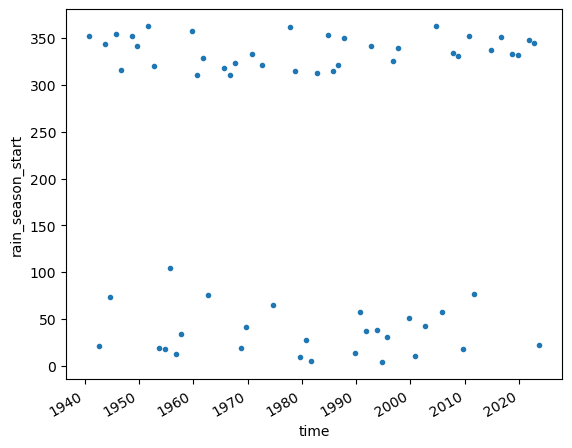

In [314]:
start.plot(marker = ".", ls = "")

In [309]:
# years when this definition failed to find a start to the season
start.time.where(np.isnan(start)).dropna("time", "any").dt.year

<xarray.DataArray 'year' (time: 21)>
array([1941, 1947, 1950, 1958, 1963, 1964, 1971, 1973, 1975, 1976, 1983,
       1988, 1998, 2001, 2003, 2006, 2012, 2013, 2015, 2017, 2020])
Coordinates:
  * time     (time) datetime64[ns] 1941-10-01 1947-10-01 ... 2020-10-01

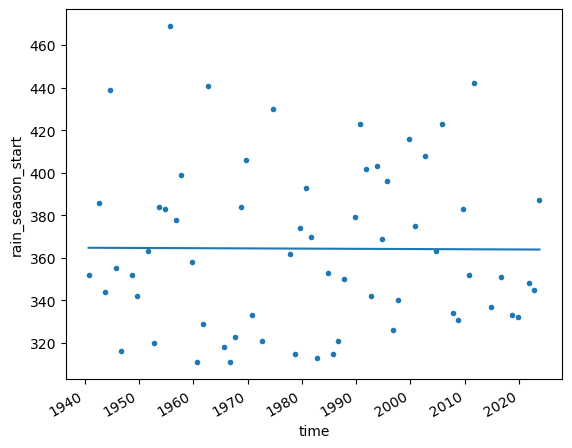

In [310]:
start3.plot(marker = ".", ls = "")
plt.gca().plot(start3.time, np.poly1d(np.polyfit(start3.time.dt.year, start3, 1))(np.sort(start3.time.dt.year)), color = "tab:blue")

In [308]:
pr2 = pr.assign_coords(time = ("time", pr.time.shift(time = -92).data))

In [ ]:
start, end, duration = rain_season(pr.sel(time = slice("1940-10-01", "2024")),
            thresh_wet_start = "10.0 mm", window_wet_start = 2, 
            window_not_dry_start = 10, window_dry_start = 20, thresh_dry_start = "5.0 mm",
            date_min_start = "01-01", date_max_end = "12-31", freq = "AS-JAN")
start2 = start.dropna("time", "any")
len(start2) # 15mm: 42; 20mm: 25; 30

In [ ]:
start2 = (start2 + 92).where(start2 < 200, 0)

In [240]:
start3 = start2 + (xr.ones_like(start2).where(start2 > 200, 0) * -365) + 92

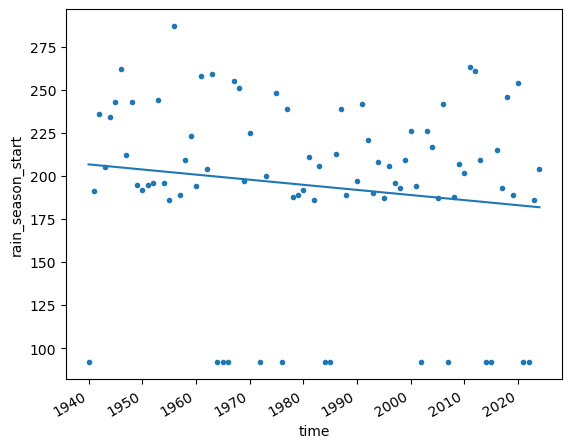

In [241]:
start3.plot(marker = ".", ls = "")
plt.gca().plot(start3.time, np.poly1d(np.polyfit(start3.time.dt.year, start3, 1))(np.sort(start3.time.dt.year)), color = "tab:blue")

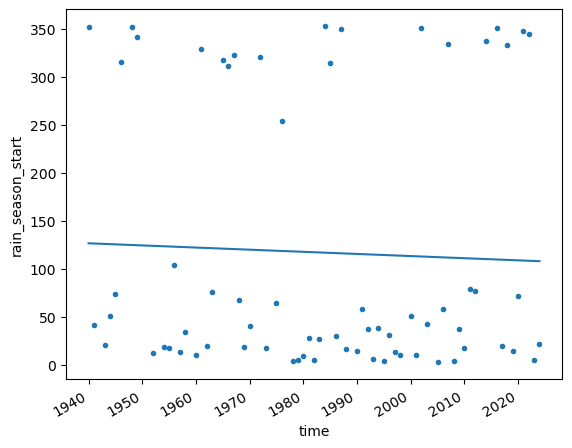

In [167]:
start.plot(marker = ".", ls = "")
plt.gca().plot(start2.time, np.poly1d(np.polyfit(start2.time.dt.year, start2, 1))(np.sort(start2.time.dt.year)), color = "tab:blue")

In [331]:
start, end, duration = rain_season(pr.sel(time = slice("1950-10-01", "2024-09-30")),
            thresh_wet_start = "25.0 mm", window_wet_start = 2, 
            window_not_dry_start = 10, window_dry_start = 20, thresh_dry_start = "5.0 mm",
            date_min_start = "10-01", date_max_start = "04-30", date_min_end = "09-30", date_max_end = "09-30", freq = "AS-OCT")
start2 = start.dropna("time", "any")
start3 = (start2 + xr.ones_like(start2).where(start2 < 200, 0) * 365)

len(start2) # 15mm: 42; 20mm: 25; 30

55

In [328]:
start.assign_coords(time = start.time.dt.year + 1).rename(time = "year").to_dataframe().to_csv("ts/era5_rs-onset_25mm.csv")

In [ ]:
start2.plot(marker = "o", ls = "")
start3.plot(marker = ".", ls = "", color = "k")

plt.gca().plot(start2.time, np.poly1d(np.polyfit(start2.time.dt.year, start2, 1))(np.sort(start2.time.dt.year)), color = "tab:blue")
plt.gca().plot(start3.time, np.poly1d(np.polyfit(start3.time.dt.year, start3, 1))(np.sort(start3.time.dt.year)), color = "k")

<xarray.DataArray 'pr' (time: 731)>
array([False, False, False, False, False, False, False, False, False,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
...
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True])
Coordinates:
  * time     (time) datetime64[ns] 1951-01-01T20:00:00 ... 1952-12-31T20:00:00
Attributes:
    units:    mm/day

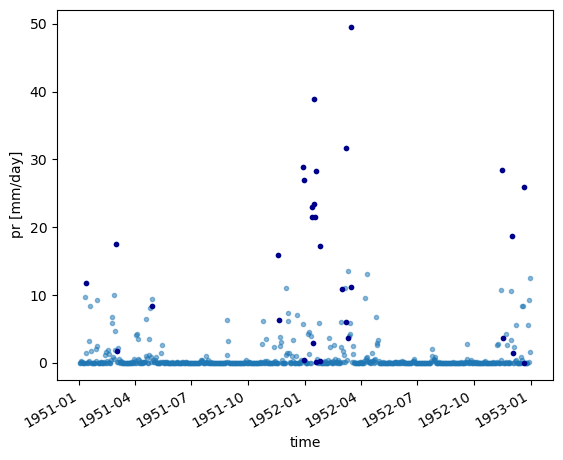

In [112]:
pr2 = pr.sel(time = slice("1951","1952"))
pr2.plot(marker = ".", ls = "", alpha = 0.5)
pr2.where(pr2.rolling(time = 2).sum() >= 15).plot(marker = ".", ls = "", color = "darkblue") # wet 2-day period

pr2.rolling(time = 10).min() < 5

In [75]:
# Years with valid rainy season start under each definition (out of 74 years):
# 25mm : 30; 20mm: 35; 15mm : 42

In [86]:
(~np.isnan(start)).sum()

<xarray.DataArray 'rain_season_start' ()>
array(42)
Attributes:
    units:         
    is_dayofyear:  1

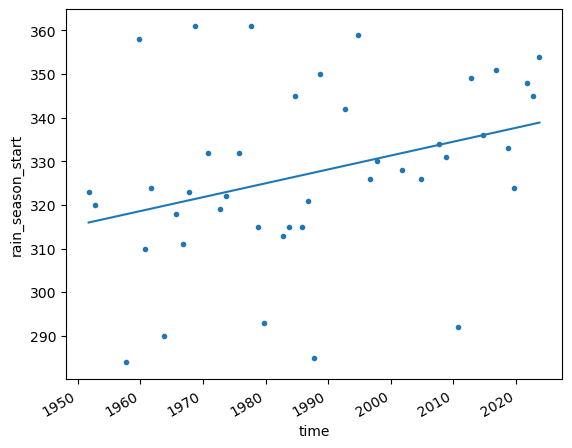

In [90]:
start.plot(marker = ".", ls = "")
plt.gca().plot(start2.time, np.poly1d(np.polyfit(start2.time.dt.year, start2, 1))(np.sort(start2.time.dt.year)), color = "tab:blue")

## WA drought definition

In [36]:
pr = xr.open_dataset("data/era5_pr_socal-baja.nc").pr
pr = pr.sel(time = slice("1940-07-01", "2024-06-30"))
pr = pr.assign_coords(offset_time = pr.time.shift(time = -184))  # hydro year starts July 1st


In [82]:
# method used in W Africa study assumes that RS is characterised by monotonic positive gradient in cumulative precipitation anomaly
anom = xr.concat([pr.sel(time = pr.offset_time.dt.year == y) - pr.sel(time = pr.offset_time.dt.year == y).mean() for y in range(1941,2025)], "time")

anom_cum = anom.resample(time = "AS-JUL").cumsum().assign_coords(time = anom.time)
anom_sm = anom_cum.rolling(time = 15, center = True).mean()
anom_diff = anom_sm.diff("time")

# identify runs of positive anomalies
rs_length = rle(xr.ones_like(anom_diff).where(anom_diff > 0, 0))

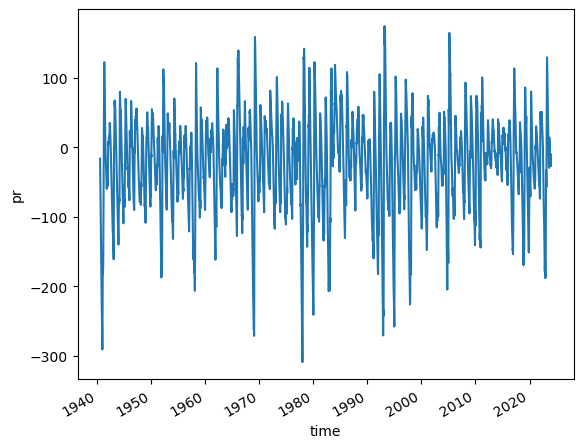

In [84]:
anom_sm.plot()

In [52]:
rs = {str(ndays) : dict(zip(["onsets", "ends", "durations"], rainy_season(pr, sm = ndays, t_0 =  183))) for ndays in [5,10,15,20]}

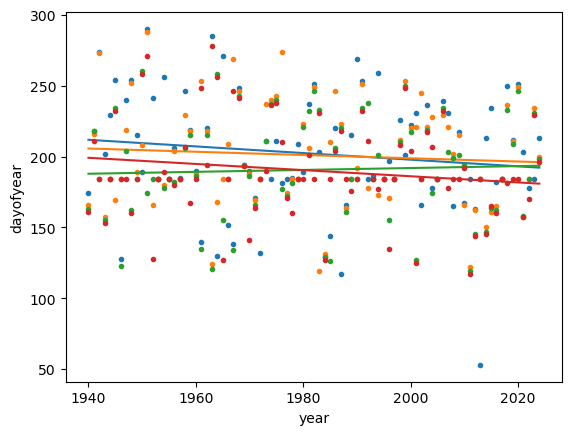

In [54]:
for ndays in rs.keys():
    onsets = (rs[ndays]["onsets"] + 183) % 365
    col = {"5" : "tab:blue", "10" : "tab:orange", "15" : "tab:green", "20":"tab:red"}[ndays]
    onsets.plot(marker = ".", ls = "", color = col)

    plt.gca().plot(onsets.year, np.poly1d(np.polyfit(onsets.year, onsets, 1))(np.sort(onsets.year)), color = col)

## Daniel Swain's suggestion

Rainy season starts after a certain amount of precip has accumulated

In [111]:
pr = xr.open_dataset("data/era5_pr_socal-baja.nc").pr
pr = pr.assign_coords(offset_time = ("time", pr.time.shift(time = 181).data))

In [112]:
pr_rscum = pr.resample(time = "AS-JUL").cumsum().assign_coords(time = pr.time)

In [148]:
rs_onset100 = pr_rscum.offset_time.where(pr_rscum >= 100).dropna("time", "any").resample(time = "AS-JUL").min()
rs_onset50 = pr_rscum.offset_time.where(pr_rscum >= 50).dropna("time", "any").resample(time = "AS-JUL").min()
rs_onset25 = pr_rscum.offset_time.where(pr_rscum >= 25).dropna("time", "any").resample(time = "AS-JUL").min()
rs_onset10 = pr_rscum.offset_time.where(pr_rscum >= 10).dropna("time", "any").resample(time = "AS-JUL").min()

Text(0.5, 0.98, 'Number of days after July 1st to exceed specified threshold ')

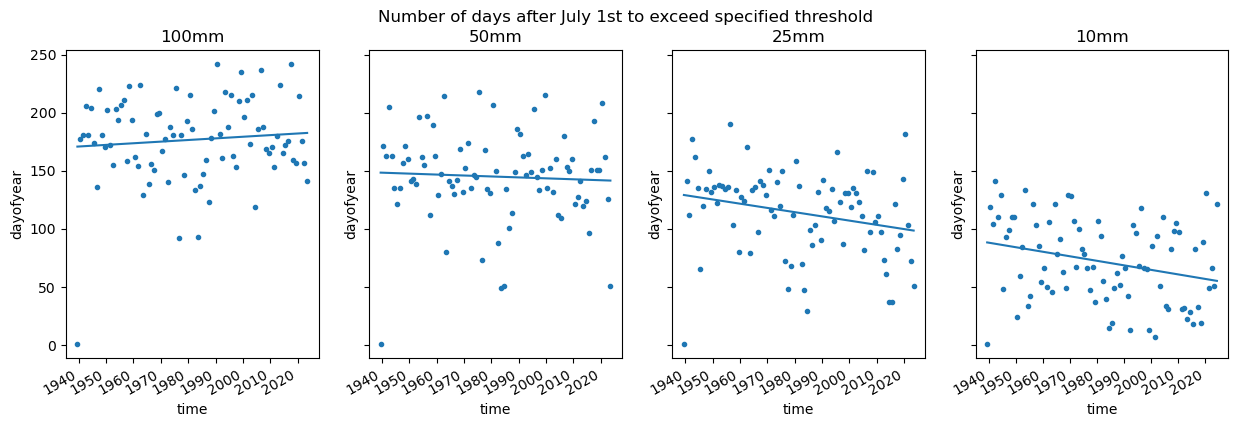

In [153]:
nc = 4
fig, axs = plt.subplots(ncols = nc, figsize = (15,4), dpi = 100, sharey = True)

for i in range(nc):
    ax = axs[i]
        
    rs_onset = [rs_onset100, rs_onset50, rs_onset25, rs_onset10][i]
    rs_onset.dt.dayofyear.plot(ax = ax, marker = ".", ls = "")
    ax.plot(rs_onset.time, np.poly1d(np.polyfit(rs_onset.time.dt.year, rs_onset.dt.dayofyear, 1))(np.sort(rs_onset.time.dt.year)), color = "tab:blue")
    
    ax.set_title(["100mm", "50mm", "25mm", "10mm"][i])
plt.suptitle("Number of days after July 1st to exceed specified threshold ")

## Theo's suggestion

Rainy season starts after n-day precip exceeds a certain wetting threshold

As with the above approach, this is quite sensitive to the choice of accumulation & period - probably better to use the first, more general approach

In [5]:
pr = xr.open_dataset("data/era5_pr_socal-baja.nc").pr
pr = pr.assign_coords(offset_time = ("time", pr.time.shift(time = 181).data))

In [6]:
pr_25d_10mm = pr.offset_time.where(pr.rolling(time = 10).sum() >= 25).dropna("time", "any").resample(time = "AS-JUL").min()

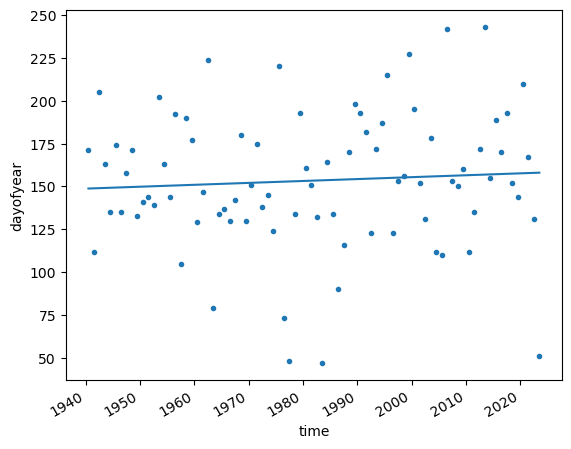

In [21]:
pr_wet.dt.dayofyear.plot(marker = ".", ls = "")
plt.gca().plot(pr_wet.time, np.poly1d(np.polyfit(pr_wet.time.dt.year, pr_wet.dt.dayofyear, 1))(np.sort(pr_wet.time.dt.year)), color = "tab:blue")


## Change in drought code

In [ ]:
dc = xr.open_dataset("data/era5_dc_socal-baja.nc").dc.sel(time = slice("1940-07",None))
dc = dc.assign_coords(offset_time = ("time", dc.time.shift(time = -184).data))
dc_diff = dc.diff("time")

dc_rs = xr.concat([dc_diff.offset_time.where(dc_diff <= -th).dropna("time", "any").resample(time = "AS-JUL").min().dt.dayofyear.expand_dims(th = [th]) for th in [10,20,50,100]], "th")

In [229]:
dc_rs.assign_coords(time = dc_rs.time.dt.year).rename(time = "year").to_pandas().transpose().to_csv("ts/era5_dc-rs.csv")

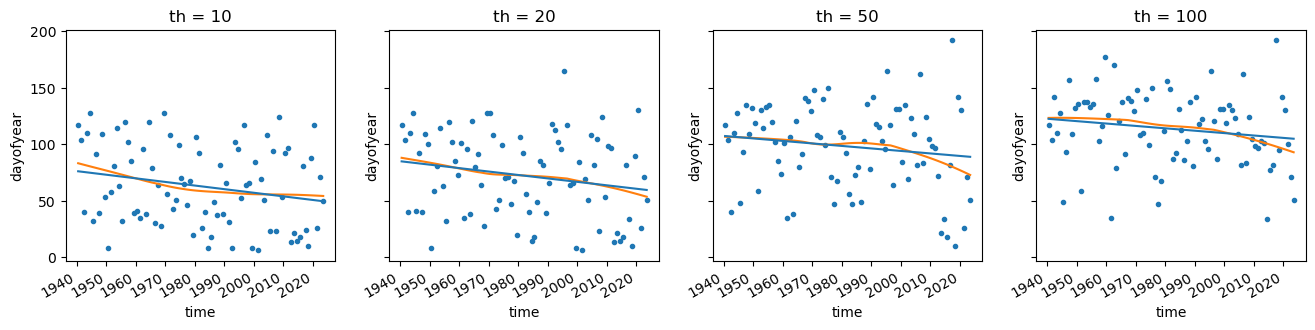

In [223]:
nc = len(dc_rs.th)
fig, axs = plt.subplots(ncols = nc, figsize = (4*nc, 3), dpi = 100, sharey = True)

for i in range(nc):
    ax = axs[i]
    ts = dc_rs.isel(th = i)
    sm = lowess(ts.values, ts.time.dt.year.values)[:,1]

    ts.plot(ax = ax, marker = ".", ls = "")
    ax.plot(ts.time, sm)
    ax.plot(ts.time, np.poly1d(np.polyfit(ts.time.dt.year, ts, 1))(np.sort(ts.time.dt.year)), color = "tab:blue")

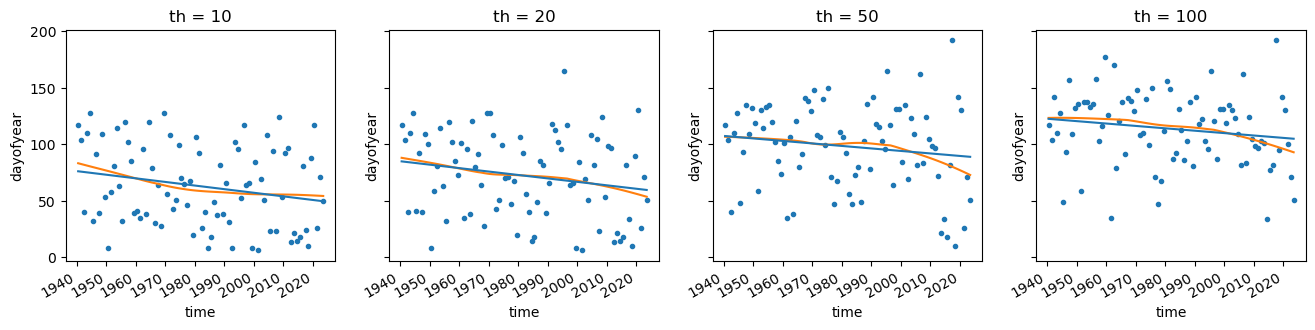

### Rolling DC

In [219]:
dc = xr.open_dataset("data/era5_dc_socal-baja.nc").dc.sel(time = slice("1940-07",None))
dc = dc.assign_coords(offset_time = ("time", dc.time.shift(time = -184).data))
dc_diff = dc.diff("time").rolling(time = 5).sum()

dc_rs = xr.concat([dc_diff.offset_time.where(dc_diff <= -th).dropna("time", "any").resample(time = "AS-JUL").min().dt.dayofyear.expand_dims(th = [th]) for th in [10,20,50,100]], "th")

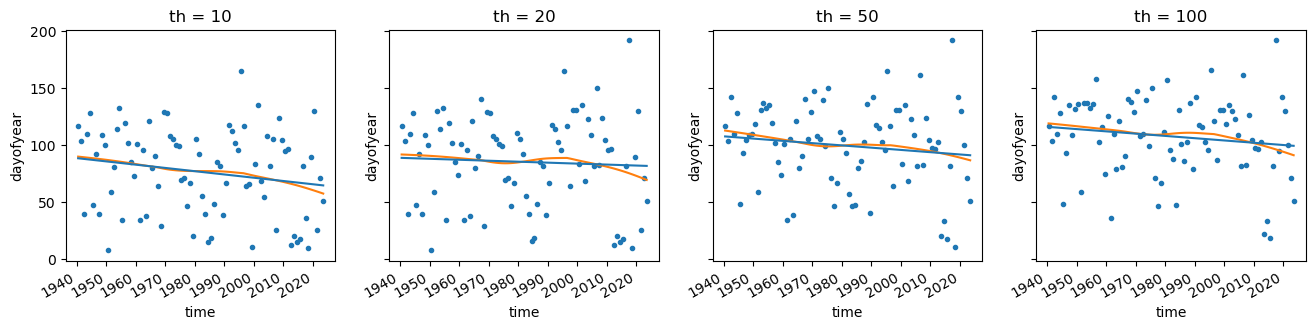

In [220]:
nc = len(dc_rs.th)
fig, axs = plt.subplots(ncols = nc, figsize = (4*nc, 3), dpi = 100, sharey = True)

for i in range(nc):
    ax = axs[i]
    ts = dc_rs.isel(th = i)
    sm = lowess(ts.values, ts.time.dt.year.values)[:,1]

    ts.plot(ax = ax, marker = ".", ls = "")
    ax.plot(ts.time, sm)
    ax.plot(ts.time, np.poly1d(np.polyfit(ts.time.dt.year, ts, 1))(np.sort(ts.time.dt.year)), color = "tab:blue")

### Timing of largest drop in DC

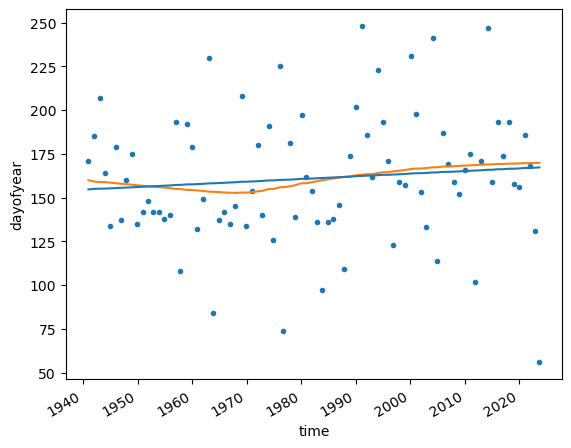

In [83]:
# split year July/June

dc = xr.open_dataset("data/era5_dc_socal-baja.nc").dc
dc = dc.assign_coords(offset_time = ("time", dc.time.shift(time = -184).data))
dc7_drop = dc.rolling(time = 7).sum().diff("time")

dc7_dates = xr.concat([dc7_drop.sel(time = slice(str(y)+"-07-01", str(y+1)+"-06-01")).idxmin() for y in range(1940,2025)], "time")
dc7_doy = dc.offset_time.dt.dayofyear.sel(time = dc7_dates).dropna("time", "any")#.sel(time = slice("1960",None))
dc7_doy.assign_coords(year = ("time", range(1940,2024))).to_dataframe().to_csv("ts/era5_dc7-doy_jj.csv")

dc7_doy.plot(marker = ".", ls = "")
plt.gca().plot(dc7_doy.time, lowess(dc7_doy.values, dc7_doy.time.dt.year.values)[:,1])
plt.gca().plot(dc7_doy.time, np.poly1d(np.polyfit(dc7_doy.time.dt.year, dc7_doy, 1))(np.sort(dc7_doy.time.dt.year)), color = "tab:blue")

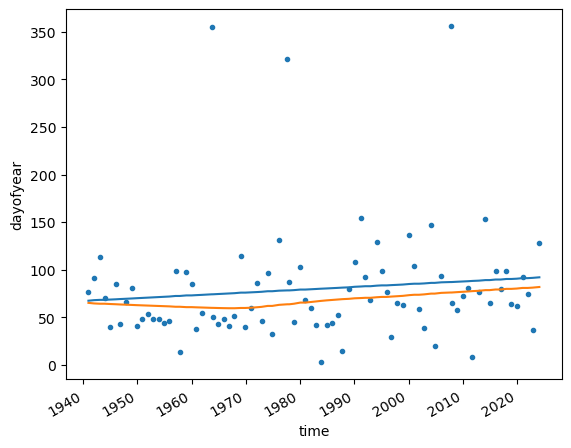

In [87]:
# split year Sep.Oct

dc = xr.open_dataset("data/era5_dc_socal-baja.nc").dc
dc = dc.assign_coords(offset_time = ("time", dc.time.shift(time = -90).data))
dc7_drop = dc.rolling(time = 7).sum().diff("time")

dc7_dates = xr.concat([dc7_drop.sel(time = slice(str(y)+"-10", str(y+1)+"-09")).idxmin() for y in range(1940,2025)], "time")
dc7_doy = dc.offset_time.dt.dayofyear.sel(time = dc7_dates).dropna("time", "any")#.sel(time = slice("1960",None))
dc7_doy.assign_coords(year = ("time", range(1940,2024))).to_dataframe().to_csv("ts/era5_dc7-doy_so.csv")

dc7_doy.plot(marker = ".", ls = "")
plt.gca().plot(dc7_doy.time, lowess(dc7_doy.values, dc7_doy.time.dt.year.values)[:,1])
plt.gca().plot(dc7_doy.time, np.poly1d(np.polyfit(dc7_doy.time.dt.year, dc7_doy, 1))(np.sort(dc7_doy.time.dt.year)), color = "tab:blue")

In [111]:
dc.time.shift(time = -152).sel(time = "2023-09-01")

<xarray.DataArray 'time' (time: 1)>
array(['2024-01-31T20:00:00.000000000'], dtype='datetime64[ns]')
Coordinates:
  * time         (time) datetime64[ns] 2023-09-01T20:00:00
    offset_time  (time) datetime64[ns] 2023-12-30T20:00:00

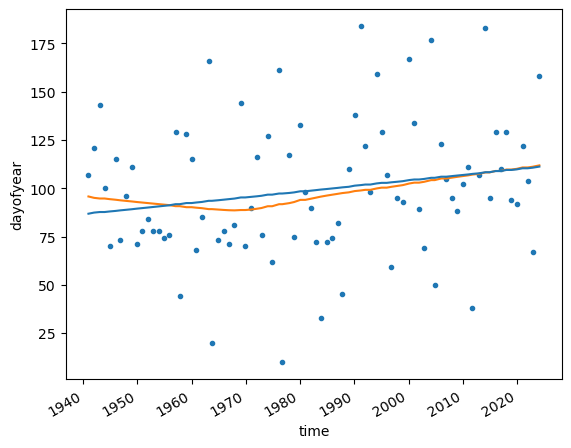

In [97]:
# only include SONDJFM

dc = xr.open_dataset("data/era5_dc_socal-baja.nc").dc
dc = dc.assign_coords(offset_time = ("time", dc.time.shift(time = -120).data))
dc7_drop = dc.rolling(time = 7).sum().diff("time")
dc7_drop = dc7_drop.sel(time = dc7_drop.time.dt.month.isin([9,10,11,12,1,2,3]))

dc7_dates = xr.concat([dc7_drop.sel(time = slice(str(y)+"-09", str(y+1)+"-08")).idxmin() for y in range(1940,2025)], "time")
dc7_doy = dc.offset_time.dt.dayofyear.sel(time = dc7_dates).dropna("time", "any")#.sel(time = slice("1960",None))
dc7_doy.assign_coords(year = ("time", range(1940,2024))).to_dataframe().to_csv("ts/era5_dc7-doy_sondjfm.csv")

dc7_doy.plot(marker = ".", ls = "")
plt.gca().plot(dc7_doy.time, lowess(dc7_doy.values, dc7_doy.time.dt.year.values)[:,1])
plt.gca().plot(dc7_doy.time, np.poly1d(np.polyfit(dc7_doy.time.dt.year, dc7_doy, 1))(np.sort(dc7_doy.time.dt.year)), color = "tab:blue")

# Relationship between Nino3.4 and monthly precipitation

In [94]:
# load precip & Nino time series
pr = xr.open_dataset("data/era5_pr_socal-baja.nc").pr
pr = pr.assign_coords(time = pr.time.dt.floor("D"))
nino34 = xr.open_dataset("data/ersst_nino34_detrended.nc").nino34

df = merge_byindex([pr.to_dataframe(), nino34.to_dataframe()]).dropna(axis = 0, how = "any")
df["month"] = df.index.month

In [ ]:
# get correlation between Nino and precip at various lags
def lagged_corr(m, lag, nmonths, df = df):
    
    df = df.rolling(nmonths, center = False).mean()
    lcor = pd.merge(df.shift(lag).loc[df.index.month == m, "nino34"],
                    df.loc[df.index.month == m, "pr"],
                    left_index = True, right_index = True).corr().values[0,1]
    return lcor

lagged_corrs = [[lagged_corr(m, lag, 1) for m in range(1,13)] for lag in range(19)]
lagged_corrs = xr.DataArray(data = lagged_corrs, name = "corr", dims = ["lag", "month"]).assign_coords(month = range(1,13), lag = range(19))

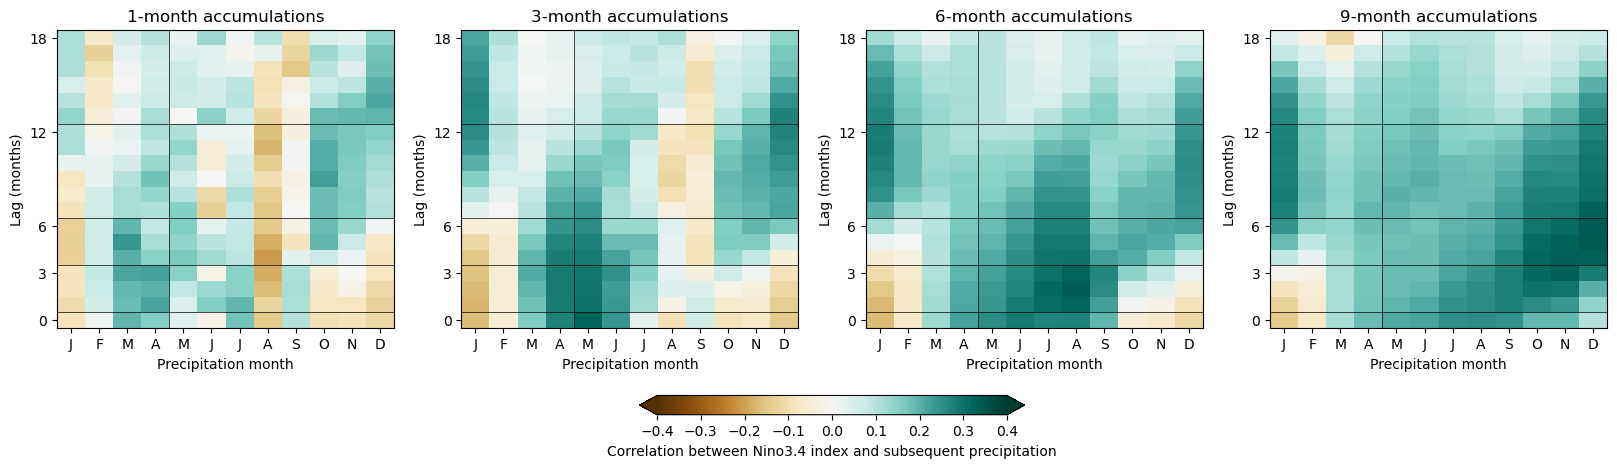

In [54]:
fig, axs = plt.subplots(ncols = 4, figsize = (20,5), dpi = 100)
plt.subplots_adjust(wspace = 0.2)

plot_kwargs = {"cmap" : "BrBG", "vmin" : -0.4, "vmax" : 0.4}

for i in range(4):
    ax = axs[i]
    nm = [1,3,6,9][i]
    
    lagged_corrs_nm = [[lagged_corr(m, lag, nm) for m in range(1,13)] for lag in range(19)]
    lagged_corrs_nm = xr.DataArray(data = lagged_corrs_nm, name = "corr", dims = ["lag", "month"]).assign_coords(month = range(1,13), lag = range(19))

    cbar = lagged_corrs_nm.plot(ax = ax, **plot_kwargs, add_colorbar = False)
    # lagged_corrs.where(~(np.abs(lagged_corrs) < 0.1)).plot(**plot_kwargs)

    yticks = [0.5,3.5,6.5,12.5,18.5]
    ax.set_yticks([y - 0.5 for y in yticks])
    ax.set_yticklabels([int(y - 0.5) for y in yticks])

    ax.set_xticks(ticks = [m + 1 for m in range(12)])
    ax.set_xticklabels(["J","F","M","A","M","J","J","A","S","O","N","D"])
    ax.axvline(4.5, color = "k", lw = 0.5)

    ax.set_ylabel("Lag (months)")
    ax.set_xlabel("Precipitation month")
    
    ax.set_title(str(nm)+"-month accumulations")
    
plt.colorbar(cbar, location = "bottom", ax = axs, fraction = 0.05, pad = 0.175, extend = "both", label = "Correlation between Nino3.4 index and subsequent precipitation")

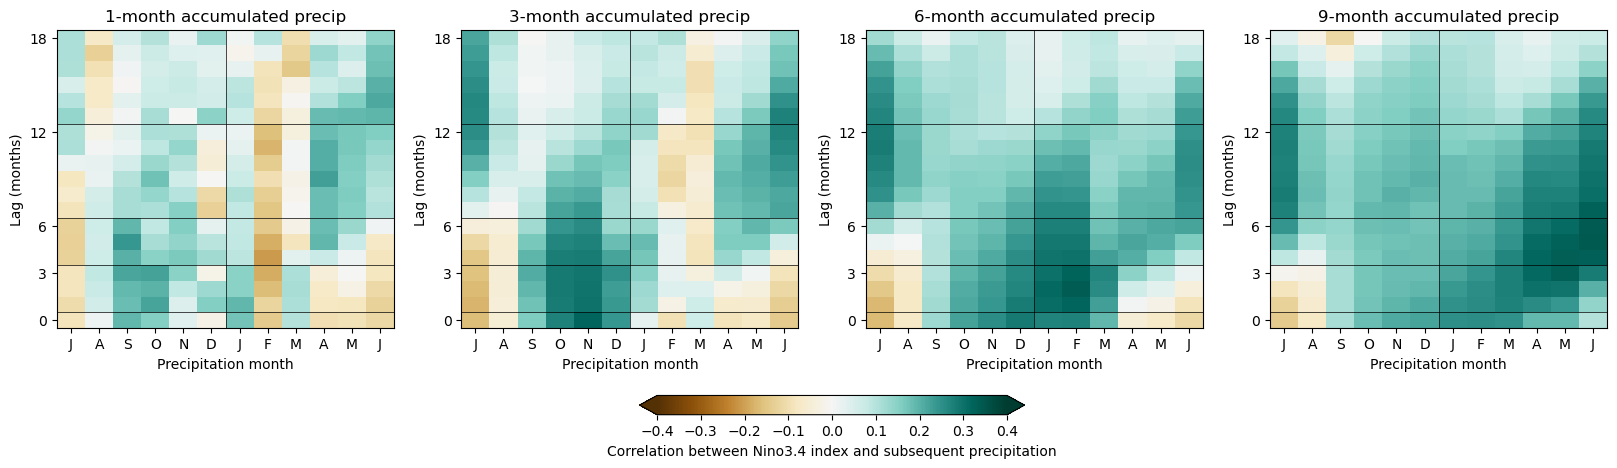

In [62]:
fig, axs = plt.subplots(ncols = 4, figsize = (20,5), dpi = 100)
plt.subplots_adjust(wspace = 0.2)

plot_kwargs = {"cmap" : "BrBG", "vmin" : -0.4, "vmax" : 0.4}

for i in range(4):
    ax = axs[i]
    nm = [1,3,6,9][i]
    
    lagged_corrs_nm = [[lagged_corr(m, lag, nm) for m in range(1,13)] for lag in range(19)]
    lagged_corrs_nm = xr.DataArray(data = lagged_corrs_nm, name = "corr", dims = ["lag", "month"]).assign_coords(month = range(1,13), lag = range(19))

    cbar = lagged_corrs_nm.plot(ax = ax, **plot_kwargs, add_colorbar = False)
    # lagged_corrs.where(~(np.abs(lagged_corrs) < 0.1)).plot(**plot_kwargs)

    yticks = [0.5,3.5,6.5,12.5,18.5]
    [ax.axhline(y, color = "k", lw = 0.5) for y in yticks]
    ax.set_yticks([y - 0.5 for y in yticks])
    ax.set_yticklabels([int(y - 0.5) for y in yticks])

    ax.set_xticks(ticks = [m + 1 for m in range(12)])
    ax.set_xticklabels(["J","A","S","O","N","D","J","F","M","A","M","J"])
    ax.axvline(6.5, color = "k", lw = 0.5)

    ax.set_ylabel("Lag (months)")
    ax.set_xlabel("Precipitation month")
    
    ax.set_title(str(nm)+"-month accumulated precip")
    
plt.colorbar(cbar, location = "bottom", ax = axs, fraction = 0.05, pad = 0.175, extend = "both", label = "Correlation between Nino3.4 index and subsequent precipitation")

# Strongest influence of Nino4.3.4 conditions seems to be on December precip, which is heavily affected by Nino3.4 up to six months previously
# Seasonally, also a strong drying effect on JJAS precip from preceding 3-6 months
# pattern is less clear for annual precip (now removed) - also some weird artefacts from crossing the wet/dry season boundary
# peak rainfall is SON: however, these months tend to be less dependent on Nino3.4
# for 8/9-month accumulation ending in December (ie for the wet season), strongest correlation with Nino at 0-3 months

In [61]:
nm = 1

lagged_corrs_nm = [[lagged_corr(m, lag, nm) for m in range(1,13)] for lag in range(19)]
lagged_corrs_nm = xr.DataArray(data = lagged_corrs_nm, name = "corr", dims = ["lag", "month"]).assign_coords(month = range(1,13), lag = range(19))
lagged_corrs_nm.sel(month = 1)

<xarray.DataArray 'corr' (lag: 19)>
array([-0.0906    , -0.10543287, -0.08657779, -0.08590577, -0.12662527,
       -0.13048987, -0.12612529, -0.08778905, -0.06403288, -0.08193533,
        0.0199642 ,  0.11002062,  0.10790223,  0.13607518,  0.09739906,
        0.0529155 ,  0.10652788,  0.1116811 ,  0.11056574])
Coordinates:
    month    int64 1
  * lag      (lag) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18

In [63]:
# manual check: correlation between OND Nino3.4 and concurrent precip

In [72]:
pr_ond = pr.resample(time = "MS").mean().rolling(time = 3).mean().groupby("time.month")[12]
pr_ndj = pr.resample(time = "MS").mean().rolling(time = 3).mean().groupby("time.month")[1]

In [88]:
nino_ond = nino34.resample(time = "MS").mean().rolling(time = 3).mean().groupby("time.month")[12]
df_3m = merge_byindex([pr.to_dataframe(), nino_ond.to_dataframe()]).dropna(axis = 0, how = "any")

In [95]:
lagged_corr(12, lag = 0, nmonths = 3)

-0.14374518036816414

In [99]:
merge_byindex([pr.to_dataframe(), nino34.to_dataframe()]).dropna(axis = 0, how = "any").corr()

,pr,nino34
pr,1.000000,-0.019986
nino34,-0.019986,1.000000


In [97]:
df_3m.corr()

,pr,nino34
pr,1.000000,-0.119496
nino34,-0.119496,1.000000


# Relationship between temperature and precipitation
Not terribly compelling in terms of the temporal distribution

In [33]:
pr = xr.open_dataset("data/era5_pr_socal-baja.nc").pr.resample(time = "MS").sum()
tas = xr.open_dataset("data/era5_tas_socal-baja.nc").tas.resample(time = "MS").mean()

pr, tas = [da.rolling(time = 3).mean().groupby("time.month")[12] for da in [pr, tas]]

In [ ]:
nino = pd.read_csv("ts/nino34_ond.csv", index_col = "year")

In [32]:
df = merge_byindex([pr.assign_coords(time = pr.time.dt.year).rename(time = "year").to_dataframe(),
                    tas.assign_coords(time = tas.time.dt.year).rename(time = "year").to_dataframe(),
                    nino]).dropna(axis = 0, how = "any")

<AxesSubplot: xlabel='tas', ylabel='pr'>

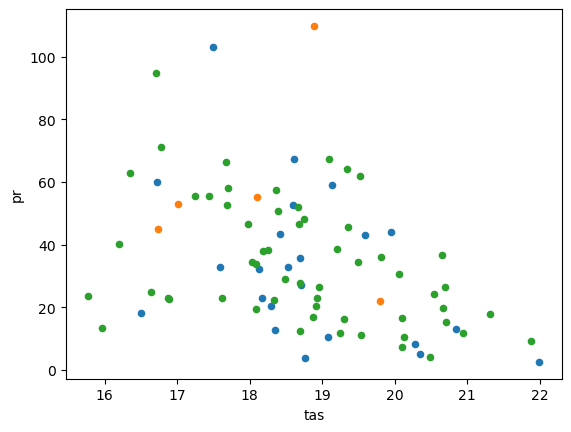

In [41]:
df.loc[df.nino34_ond <= -1].plot(kind = "scatter", x = "tas", y = "pr")
df.loc[(df.nino34_ond > -1) & (df.nino34_ond < 1)].plot(ax = plt.gca(), kind = "scatter", x = "tas", y = "pr", color = "tab:green")
df.loc[df.nino34_ond >= 1].plot(ax = plt.gca(), kind = "scatter", x = "tas", y = "pr", color = "tab:orange")

In [19]:
plt.scatter(*[da.sel(time = slice(None,"1980")) for da in [pr, tas]], color = "tab:blue")
plt.scatter(*[da.sel(time = slice("1980","2000")) for da in [pr, tas]], color = "tab:green")
plt.scatter(*[da.sel(time = slice("2000","2020")) for da in [pr, tas]], color = "orange")
plt.scatter(*[da.sel(time = slice("2020",None)) for da in [pr, tas]], color = "darkred")

# Trends in Dec precip variability

In [120]:
pr = xr.open_dataset("data/era5_pr_socal-baja.nc").pr.groupby("time.month")[12]

Text(0.5, 1.0, 'Rolling 15-year SD of\nDecember accumulated precip')

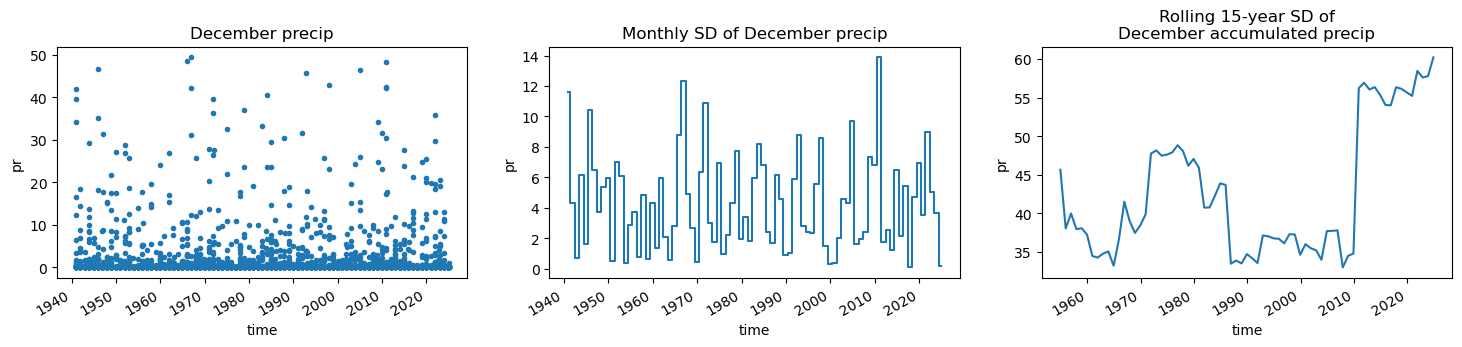

In [137]:
nc = 3
fig, axs = plt.subplots(ncols = nc, figsize = (nc*6, 3), dpi = 100)

ax = axs[0]
pr.plot(ax = ax, marker = ".", ls = "")
ax.set_title("December precip")

ax = axs[1]
pr.resample(time = "AS-DEC").std().plot(ax = ax, drawstyle = "steps-mid")
ax.set_title("Monthly SD of December precip")

ax = axs[2]
pr.resample(time = "AS-DEC").sum().rolling(time = 15, center = False).std().plot(ax = ax)
ax.set_title("Rolling 15-year SD of\nDecember accumulated precip")

# Further exploration after talking to Sam on 23rd

## January accumulated DSR

No clear trend

In [18]:
dsr = xr.open_dataset("data/era5_dsr_socal-baja.nc").dsr.sel(time = slice("1960",None))

In [19]:
dsr_j15 = dsr.rolling(time = 15).sum().sel(time = dsr.time.dt.dayofyear == 15)
dsr_j15 = dsr_j15.assign_coords(time = dsr_j15.time.dt.year).rename(time = "year")

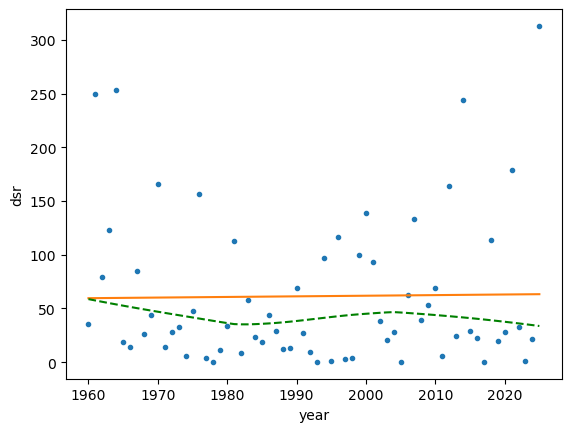

In [26]:
dsr_j15.plot(marker = ".", ls = "")
xyline(dsr_j15.year, dsr_j15.values, ax = plt.gca())
plt.gca().plot(dsr_j15.year, lowess(dsr_j15.values, dsr_j15.year.values)[:,1], color = "green", ls = "--")

## Dec-Jan accumulated DSR

slight increase, higher variability

In [27]:
dsr = xr.open_dataset("data/era5_dsr_socal-baja.nc").dsr

In [30]:
dsr_dj = dsr.sel(time = dsr.time.dt.month.isin([12,1])).resample(time = "AS-DEC").mean()
dsr_dj = dsr_dj.assign_coords(time = dsr_dj.time.dt.year).rename(time = "year")

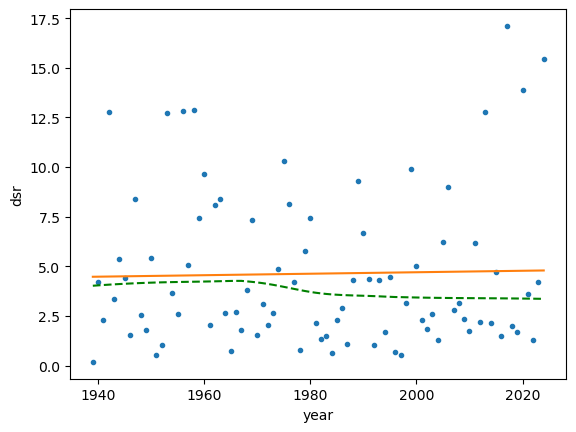

In [31]:
dsr_dj.plot(marker = ".", ls = "")
xyline(dsr_dj.year, dsr_dj.values, ax = plt.gca())
plt.gca().plot(dsr_dj.year, lowess(dsr_dj.values, dsr_dj.year.values)[:,1], color = "green", ls = "--")

## Trends in DJFM rainfall
Clear increasing trend

In [41]:
pr = xr.open_dataset("data/era5_pr_socal-baja.nc").pr.sel(time = slice(None, "2024-11"))

In [46]:
pr_djfm = pr.sel(time = pr.time.dt.month.isin([2,3])).resample(time = "AS-DEC").mean()
pr_djfm = pr_djfm.assign_coords(time = pr_djfm.time.dt.year).rename(time = "year")

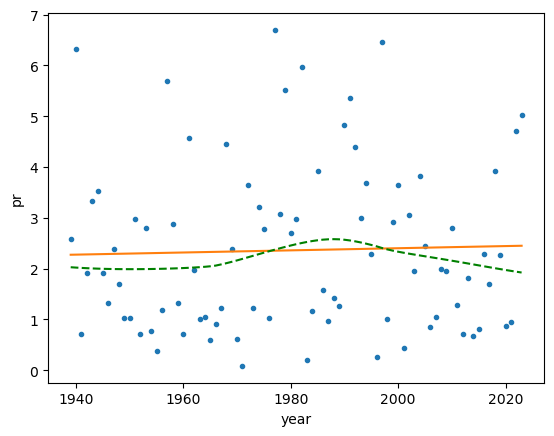

In [47]:
pr_djfm.plot(marker = ".", ls = "")
xyline(pr_djfm.year, pr_djfm.values, ax = plt.gca())
plt.gca().plot(pr_djfm.year, lowess(pr_djfm.values, pr_djfm.year.values)[:,1], color = "green", ls = "--")

## Trends in DJ/J drought code
Clear increasing trend

In [32]:
dc = xr.open_dataset("data/era5_dc_socal-baja.nc").dc

In [48]:
dc_dj = dc.sel(time = dc.time.dt.month.isin([1])).resample(time = "AS-DEC").mean()
dc_dj = dc_dj.assign_coords(time = dc_dj.time.dt.year).rename(time = "year")

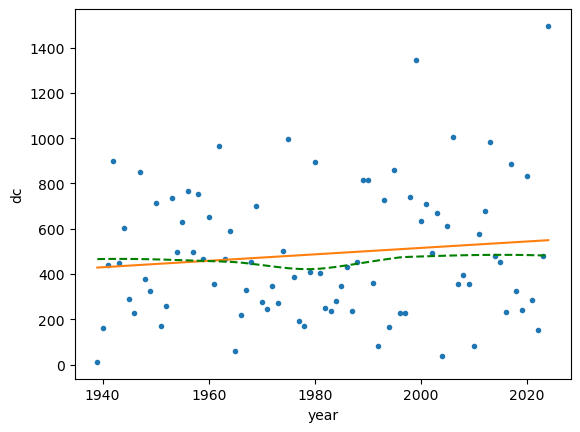

In [49]:
dc_dj.plot(marker = ".", ls = "")
xyline(dc_dj.year, dc_dj.values, ax = plt.gca())
plt.gca().plot(dc_dj.year, lowess(dc_dj.values, dc_dj.year.values)[:,1], color = "green", ls = "--")

## Alternative drought onset definitions

### DOY on which a certain percentile of the climatological mean precip falls

In [3]:
pr = xr.open_dataset("data/era5_pr_socal-baja.nc").pr.sel(time = slice("1940-02", None))
pr = pr.assign_coords(offset_time = ("time", pr.time.shift(time = -92).data))
# pr = pr.sel(time = pr.time.dt.month.isin([10,11,12,1,2]))

In [170]:
pr_clim = pr.resample(time = "AS-OCT").sum().sel(time = slice("1990", "2019")).mean()

In [174]:
# proportion of climatology usually received between October 1st and December 31st

prop_ond = pr.sel(time = pr.time.dt.month.isin([10,11,12])).sel(time = slice("1990", "2019")).resample(time = "AS-OCT").sum() / pr_clim
prop_ond = prop_ond.assign_coords(time = prop_ond.time.dt.year+1).rename(time = "year")

In [180]:
mprop_ond = prop_ond.mean()

In [179]:
prop_ond.plot(marker = ".", ls = "")
xyline(prop_ond.year, prop_ond.values, ax = plt.gca())
plt.gca().plot(prop_ond.year, lowess(prop_ond.values, prop_ond.year.values)[:,1], color = "green", ls = "--")
# plt.gca().axhline(155, color = "magenta", ls = "--")

In [5]:
365-y_offset(10)

90

In [186]:
doy = pr.offset_time.where(pr.resample(time = "AS-OCT").cumsum() >= (mprop_ond * pr_clim / 2)).dropna("time", "any").resample(time = "AS-OCT").min().dt.dayofyear
doy = doy.assign_coords(time = doy.time.dt.year+1).rename(time = "year")

In [187]:
doy.to_dataframe().to_csv("ts/era5_doy-clim30pc.csv")

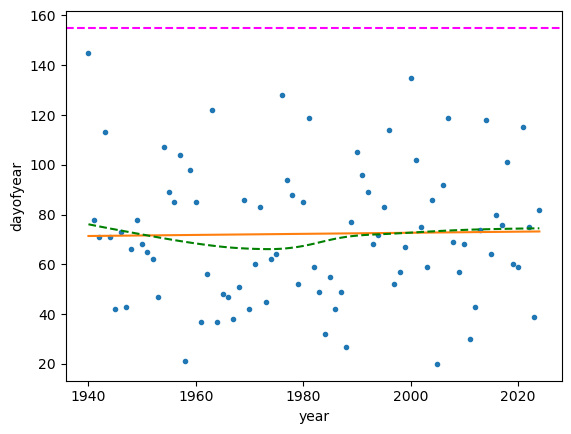

In [188]:
doy.plot(marker = ".", ls = "")

xyline(doy.year, doy.values, ax = plt.gca())
plt.gca().plot(doy.year, lowess(doy.values, doy.year.values)[:,1], color = "green", ls = "--")
plt.gca().axhline(155, color = "magenta", ls = "--")

### DOY on which a certain percentile of the climatological mean precip falls

In [169]:
pr = xr.open_dataset("data/era5_pr_socal-baja.nc").pr.sel(time = slice("1940-02", None))
pr = pr.assign_coords(offset_time = ("time", pr.time.shift(time = -92).data))
# pr = pr.sel(time = pr.time.dt.month.isin([10,11,12,1,2]))

In [170]:
pr_clim = pr.resample(time = "AS-OCT").sum().sel(time = slice("1990", "2019")).mean()

In [171]:
doy = pr.offset_time.where(pr.resample(time = "AS-OCT").cumsum() >= (0.30 * pr_clim)).dropna("time", "any").resample(time = "AS-OCT").min().dt.dayofyear
doy = doy.assign_coords(time = doy.time.dt.year+1).rename(time = "year")

In [172]:
doy.to_dataframe().to_csv("ts/era5_doy-clim30pc.csv")

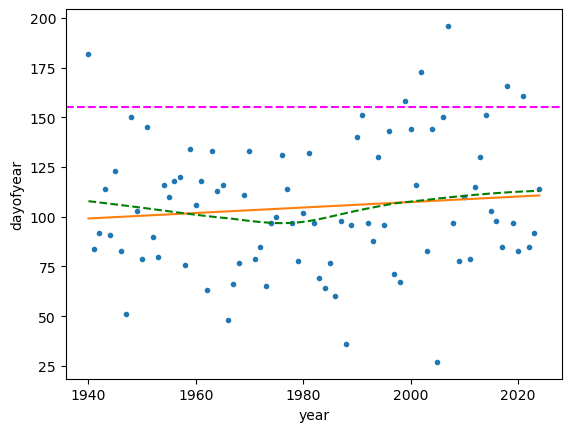

In [173]:
doy.plot(marker = ".", ls = "")

xyline(doy.year, doy.values, ax = plt.gca())
plt.gca().plot(doy.year, lowess(doy.values, doy.year.values)[:,1], color = "green", ls = "--")
plt.gca().axhline(155, color = "magenta", ls = "--")

In [168]:
# proportion of climatology usually received between October 1st and December 31st

In [132]:
prop_ond = pr.sel(time = pr.time.dt.month.isin([10,11,12])).resample(time = "AS-OCT").sum() / pr_clim
prop_ond = prop_ond.assign_coords(time = prop_ond.time.dt.year+1).rename(time = "year")

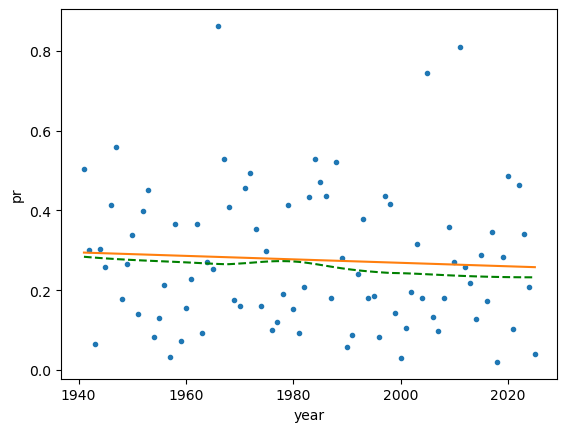

In [133]:
prop_ond.plot(marker = ".", ls = "")
xyline(prop_ond.year, prop_ond.values, ax = plt.gca())
plt.gca().plot(prop_ond.year, lowess(prop_ond.values, doy.year.values)[:,1], color = "green", ls = "--")
# plt.gca().axhline(155, color = "magenta", ls = "--")

In [127]:
prop_ond.mean()

<xarray.DataArray 'pr' ()>
array(0.27616525, dtype=float32)

# Percentile drop in drought code?

Still an arbitrary threshold though...

In [169]:
yshift = 365 - y_offset(9)

In [170]:
dc = xr.open_dataset("data/era5_dc_socal-baja.nc").dc
dc = dc.assign_coords(offset_time = ("time", dc.time.shift(time = -yshift).data))

pr = xr.open_dataset("data/era5_pr_socal-baja.nc").pr
pr = pr.assign_coords(offset_time = ("time", pr.time.shift(time = -yshift).data))

Text(0.5, 1.0, 'First drop of more than 20%')

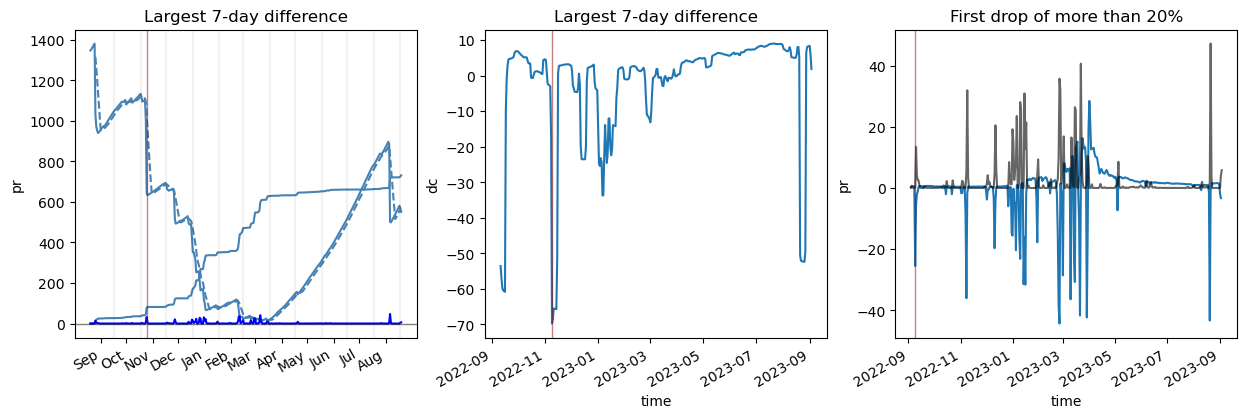

In [171]:
hy = 2023

dc_hy = dc.sel(time = dc.offset_time.dt.year == hy)
pr_hy = pr.sel(time = pr.offset_time.dt.year == hy)

days = dc_hy.time
labelticks = [d.values for d in days if d.dt.day == 15]
labels = [days[i].dt.strftime("%b").values for i in range(len(days)) if (days[i].dt.day) == 15]

fig, axs = plt.subplots(ncols = 3, figsize = (15, 4), dpi = 100)

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

ax = axs[0]
dc_hy.plot(ax = ax, color = "steelblue")
dc_hy.rolling(time = 7, center = False).mean().plot(ax = ax, color = "steelblue", ls = "--")
pr_hy.cumsum().plot(ax = ax, color = "steelblue")
pr_hy.plot(ax = ax, color = "blue")
ax.axhline(0, color = "k", alpha = 0.5, lw = 1)

ax.axvline(dc_hy.rolling(time = 7, center = False).mean().diff("time", label = "upper").idxmin().values, color = "darkred", lw = 1, alpha = 0.5)

[ax.axvline(d.values, color = "k", alpha = 0.05) for d in days if d.dt.day == 1]
ax.set_xticks(labelticks)
ax.set_xticklabels(labels)
ax.set_xlabel("")

ax.set_title("Largest 7-day difference")

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

ax = axs[1]

dc_hy.diff("time").rolling(time = 7).mean().plot(ax = ax)
ax.axvline(dc_hy.rolling(time = 7, center = False).mean().diff("time", label = "upper").idxmin().values, color = "darkred", lw = 1, alpha = 0.5)
ax.set_title("Largest 7-day difference")

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

ax = axs[2]
(dc_hy.diff("time", label = "lower") / dc_hy * 100).plot(ax = ax)
pr_hy.plot(ax = ax, color = "k", alpha = 0.6)

first_drop = dc_hy.time.where((dc_hy.diff("time", label = "lower") / dc_hy) < -0.2).dropna("time", "any").idxmin()
ax.axvline(first_drop.values, color = "darkred", lw = 1, alpha = 0.5)
ax.set_title("First drop of more than 20%")

In [172]:
first_drops = []
for hy in range(1941,2025):
    dc_hy = dc.sel(time = dc.offset_time.dt.year == hy)
    
    rel_drop = dc_hy.diff("time", label = "lower") / dc_hy
    
    if rel_drop.min() < -0.2:
        first_drop = dc_hy.time.where(rel_drop < -0.2).dropna("time", "any").idxmin()
    else:
        first_drop = rel_drop.idxmin()
        
    first_drops.append(first_drop)

first_drops = xr.concat(first_drops, "time")
first_drops = first_drops.assign_coords(time = first_drops.time)

# Timing of Santa Ana winds

In [26]:
saw = pd.read_csv("R1DSAWRI_010148_123118_red.txt", sep = " ", index_col = "dt")
saw.index = [datetime(int(d[-2:]) + 1900, int(d[:2]), int(d[3:5])) if int(d[-2:]) > 20 else datetime(int(d[-2:]) + 2000, int(d[:2]), int(d[3:5])) for d in saw.index]
saw.to_csv("ts/sawri.csv")

In [68]:
saw["hy_doy"] = saw.to_xarray().index.shift(index = -120).dt.dayofyear

In [80]:
sc_saw = saw.R1D_SAWRI.rolling(15).mean().groupby(saw.hy_doy).mean()

In [84]:
sc_saw.to_csv("saw-smoothed-cycle.csv")

<AxesSubplot: xlabel='hy_doy'>

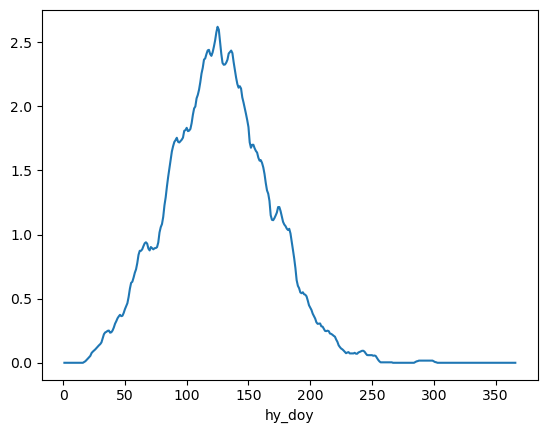

In [82]:
sc_saw.plot()